In [ ]:
import pandas as pd                                                                                      # type: ignore
import matplotlib.pyplot as plt                                                                          # type: ignore
import seaborn as sns                                                                                    # type: ignore
import scipy.stats as stats                                                                              # type: ignore
import plotly.express as px                                                                              # type: ignore
import plotly.graph_objects as go                                                                        # type: ignore
from plotly.subplots import make_subplots                                                                # type: ignore
from sklearn.impute import SimpleImputer                                                                 # type: ignore
from sklearn.model_selection import train_test_split                                                     # type: ignore
from sklearn.preprocessing import StandardScaler                                                         # type: ignore
from sklearn.linear_model import LinearRegression                                                        # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error,r2_score      # type: ignore 

In [2]:
class Regression_Model:
    def __init__(self, dataset_name, test_size=0.2, random_state=42, Scaling_Thr=100, corrlate_Thr=0.1, top_corrlate=3, imputation_strategy="mean", MAX_FEATURES_FOR_PAIRPLOT = 6):
        try:
            self.dataset = pd.read_csv(dataset_name)
            if self.dataset.empty:
                raise ValueError("Dataset is empty after loading.")
        except FileNotFoundError:
            print(f"❌ Error: The file '{dataset_name}' was not found.")
            return
        except pd.errors.EmptyDataError:
            print("❌ Error: The dataset file is empty.")
            return
        except Exception as e:
            print(f"❌ Unexpected error loading dataset: {e}")
            return
        
        self.target  = self.dataset.columns[-1]
        self.model   = LinearRegression()
        self.imputer = SimpleImputer(strategy=imputation_strategy)
        self.scaler  = StandardScaler()
        self.X_train = self.X_test = self.y_train = self.y_test = None
        self.X = self.dataset.drop(self.target, axis=1)
        self.y = self.dataset[self.target]
        self.test_size    = test_size
        self.random_state = random_state
        self.Scaling_Thr  = Scaling_Thr
        self.corrlate_Thr = corrlate_Thr
        self.top_corrlate = top_corrlate
        self.Max_Features = MAX_FEATURES_FOR_PAIRPLOT
        plt.style.use('ggplot')
        sns.set_theme(style="whitegrid")
        print(f"✅ Dataset Load successfully !! shape : {self.dataset.shape}")
        
        if not self.suitable_reg_dataset(self.dataset):
            print("❌ This dataset is not suitable for regression. You should use classification instead.")
            self.dataset = None
            return
###################################################################################################
    def suitable_reg_dataset(self,data):
        """ ---------- check the dataset if it is suitable for regression or not ----------
            - checks whether the target column is present in the data or not.
            - check the target column type if it is numerical or not        to determine if it is a regression problem or not.
            - Checking Unique Values in Target Column                       to determine if it is a Regression Problem or not
            - Checking for Missing Values                                   to ensure that the data is clean
            - Checking Column Data Types                                    to ensure that all columns are numerical 
            - Checking Numerical Feature Scaling                            to ensure that all features are on the same scale
            - Checking for Linear Relationship between Features and Target  to ensure that the data is suitable for Linear Regression
            - Splitting Data into Train/Test Sets """
        if self.target not in self.dataset.columns:
            print(f"❌ Target column '{self.target}' not found in the dataset")
            return False
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 1: Checking Target Column Type ---------------------")
        if data[self.target].dtype not in ['int64', 'float64']:
            print("    ⚠️ Target variable is not numerical. The dataset might not be suitable for regression.")
            return False
        print("✅ Target variable is numerical.")
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 2: Checking Unique Values in Target Column ---------------------")
        unique_values = data[self.target].nunique()
        if unique_values <= 10:
            print(f"    ⚠️ Target variable has only {unique_values} unique values. This might indicate a classification problem.")
            return False
        print(f"✅ Target variable has {unique_values} unique values.")
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 3: Checking Missing Values ---------------------")
        missing_percent = self.dataset.isnull().sum() / len(self.dataset) * 100
        if missing_percent[self.target] > 20:
            print(f"    ⚠️ Target column has {missing_percent[self.target]:.1f}% missing values. Consider handling missing data.")
        print("✅ Missing values check completed.")
        
        missing_values = self.dataset.isnull().sum().sum()
        if missing_values > 0:
            print(f"    ⚠️ Warning: Found {missing_values} missing values in the dataset!")
            imputer = self.imputer
            self.dataset = pd.DataFrame(imputer.fit_transform(self.dataset), columns=self.dataset.columns)
            missing_after = self.dataset.isnull().sum().sum()
            if missing_after == 0:
                print(f"✅ Missing values handled successfully! No missing values left.")
            else:
                print(f"    ⚠️ Some missing values still exist ({missing_after}). Consider different strategies.")
                return False
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 4: Checking Column Data Types ---------------------")
        categorical_columns = self.dataset.select_dtypes(include=['object']).columns.tolist()
        if categorical_columns:
            print(f"    ⚠️ Found categorical columns: {categorical_columns}")
            MAX_CATEGORIES = 15
            for col in categorical_columns:
                if self.dataset[col].nunique() > MAX_CATEGORIES:
                    print(f"    ⚠️ Column '{col}' has too many categories ({self.dataset[col].nunique()}). Consider encoding differently.")
            
            self.dataset = pd.get_dummies(self.dataset, columns=categorical_columns, drop_first=True)   # [drop_first=True] to avoid multi-collinearity
            print(f"✅ Categorical columns encoded !! New shape: {self.dataset.shape}") 
        else:
            print("✅ No categorical columns found. Data is already numerical.")
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 5: Checking Numerical Feature Scaling ---------------------")
        numerical_columns = self.dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
        high_variance_columns = []
        Scaling_Thr = self.Scaling_Thr
        
        for col in numerical_columns:
            min_val, max_val = self.dataset[col].min(), self.dataset[col].max()
            range_val = max_val - min_val
            if range_val > Scaling_Thr:
                high_variance_columns.append(col)
        
        if high_variance_columns:
            print(f"    ⚠️ High variance detected in columns: {high_variance_columns}")
            scaler = self.scaler
            self.dataset[high_variance_columns] = scaler.fit_transform(self.dataset[high_variance_columns])
            print(f"✅ Scaling applied to columns: {high_variance_columns}")
        else:
            print("✅ No scaling needed. Data distribution is balanced.")
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 5.1: Checking for Linear Relationship between Features and Target ---------------------")
        if self.dataset.empty:
            print("❌ Dataset is empty after processing. Check your preprocessing steps.")
            return False
        elif self.target not in self.dataset.columns:
            print(f"❌ Target column '{self.target}' not found after preprocessing.")
            return False
        correlations      = self.dataset.corr()[self.target].drop(self.target)
        correlation_thr   = self.corrlate_Thr
        selected_features = correlations[abs(correlations) > correlation_thr].index.tolist()    # contains the features that have a linear relationship with the target
        
        if len(selected_features) == 0:
            print("    ⚠️ No strongly correlated features found! Consider feature engineering.")
        else:
            print(f"✅ Keeping {len(selected_features)} features from {len(self.dataset.columns)-1} with correlation > {correlation_thr}:\n{selected_features}")
        
        if selected_features:
            self.dataset = self.dataset[selected_features + [self.target]]
            print(f"✅ Features filtered !! New dataset shape: {self.dataset.shape}")
        else:
            print("⚠️ No features met the correlation threshold. Keeping all original features.")
        #-----------------------------------------------------
        
        print("\n📊 --------------------- Step 6: Checking Linear Relationship with Target ---------------------")
        if self.dataset.empty:
            print("❌ Dataset is empty after processing. Check your preprocessing steps.")
            return False
        elif self.target not in self.dataset.columns:
            print(f"❌ Target column '{self.target}' not found after preprocessing.")
            return False
        correlations = self.dataset.corr()[self.target].drop(self.target).sort_values(ascending=False)
        print(f"✅ Correlation with Target:\n{correlations}")
        
        top_features = correlations[abs(correlations) > correlation_thr].index.tolist()  
        if top_features:
            plt.figure(figsize=(12, 6))
            num_features_to_plot = min(len(top_features), self.top_corrlate)
            for feature in top_features[:num_features_to_plot]:  
                sns.regplot(x=self.dataset[feature], y=self.dataset[self.target], line_kws={"color": "red"}, scatter_kws={'alpha':0.5}, x_jitter=0.1)
                plt.title(f"Relationship between {feature} and {self.target}")
                plt.show()
        else:
            print("    ⚠️ No strong linear relationships detected.")
        #-----------------------------------------------------
        
        print("📊 --------------------- Step 7: Splitting Data into Train/Test Sets ---------------------")
        X = self.dataset.drop(self.target, axis=1)
        y = self.dataset[self.target]
        if self.dataset.shape[1] <= 1:
            print("❌ No valid features left after preprocessing! Check correlation threshold or dataset quality.")
            return False
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, shuffle=True)
        print(f"✅ Data split completed!")
        print(f"   - Training set size: {self.X_train.shape[0]} samples")
        print(f"   - Testing  set size: {self.X_test.shape[0]} samples")
        
        return True
###################################################################################################
    def train(self):
        if self.dataset is None:
            print("❌ Cannot train the model. The dataset is not suitable for regression.")
            return
        print("🚀 --------------------- Training Linear Regression Model ---------------------")
        self.model.fit(self.X_train, self.y_train)
        train_score = self.model.score(self.X_train, self.y_train) * 100
        test_score  = self.model.score(self.X_test, self.y_test) * 100
        
        print("✅ Model Training Completed!")
        print(f"   - Train Score: {train_score:.2f} %")
        print(f"   - Test  Score: {test_score:.2f} %")
        print(f"   - Coefficients:\n{self.model.coef_}")
        print(f"   - Intercept: {round(self.model.intercept_, 2)}")
###################################################################################################
    def evaluate(self):
        if self.dataset is None:
            print("❌ Cannot train the model. The dataset is not suitable for regression.")
            return
        print("\n🚀 --------------------- Evaluating Model Performance ---------------------")
        y_pred = self.model.predict(self.X_test)
        
        mae   = mean_absolute_error(self.y_test, y_pred)
        mse   = mean_squared_error(self.y_test, y_pred)
        medae = median_absolute_error(self.y_test, y_pred)
        r2    = r2_score(self.y_test, y_pred)
        
        print("✅ Model Evaluation Completed!")
        print(f"   - Mean   Absolute Error (MAE)   : {mae:.2f}")
        print(f"   - Mean   Squared  Error (MSE)   : {mse:.2f}")
        print(f"   - Median Absolute Error (MedAE) : {medae:.2f}")
        print(f"   - R2 Score: {r2:.2f}")
###################################################################################################
    def plot(self):
        if self.dataset is None:
            print("❌ Cannot train the model. The dataset is not suitable for regression.")
            return
        print("📊 Generating Interactive Plots...")
        dataset_copy = self.dataset.copy()
        
        # 1️⃣ Pair Plot "relations between features"
        selected_cols = dataset_copy.columns[:self.Max_Features]
        fig = px.scatter_matrix(dataset_copy, dimensions=selected_cols, color=self.target)
        fig = px.scatter_matrix(dataset_copy, dimensions=dataset_copy.columns[:-1], color=self.target)
        fig.update_layout(title="Pair Plot - Relationship Between Features")
        fig.show()
        
        # 2️⃣ Histogram , Box Plot 
        fig = make_subplots(rows=1, cols=2, subplot_titles=("Feature Distributions", "Box Plot - Outliers"),
                            column_widths=[0.6, 0.4])
        for col in dataset_copy.columns:
            fig.add_trace(go.Histogram(x=dataset_copy[col], name=col, opacity=0.7), row=1, col=1)
            fig.add_trace(go.Box(y=dataset_copy[col], name=col, boxpoints='outliers'), row=1, col=2)
        fig.update_layout(title="Feature Distribution & Outlier Analysis", showlegend=False)
        fig.show()
        
        # 3️⃣ Heatmap 
        corr_matrix = dataset_copy.corr()
        fig = go.Figure(data=go.Heatmap(z=corr_matrix.values, x=corr_matrix.columns, y=corr_matrix.columns, 
                                colorscale='rdylbu', text=corr_matrix.values, texttemplate="%{text:.2f}"))
        fig.update_layout(title="Correlation Heatmap")
        fig.show()
        
        # 4️⃣ Residual Plot
        y_pred = self.model.predict(self.X_test)
        residuals = self.y_test - y_pred
        fig = px.scatter(x=y_pred, y=residuals, title="Residual Plot", labels={"x": "Predicted Values", "y": "Residuals"})
        fig.add_hline(y=0, line_dash="dash", line_color="red") 
        fig.show()
        
        # 5️⃣ Q-Q Plot
        qq = stats.probplot(residuals, dist="norm")
        fig = px.scatter(x=qq[0][0], y=qq[0][1], title="Q-Q Plot of Residuals",
                        labels={"x": "Theoretical Quantiles", "y": "Sample Quantiles"})
        fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines', line=dict(color='red', dash='dash')))
        fig.show()
        
        # 6️⃣ Actual vs Predicted Plot
        fig = px.scatter(x=self.y_test, y=y_pred, title="Actual vs Predicted Values",
                        labels={"x": "Actual Values", "y": "Predicted Values"})
        fig.add_trace(go.Scatter(x=self.y_test, y=self.y_test, mode='lines', line=dict(color='red', dash='dash')))
        fig.show()
        
        # 7️⃣ Feature Importance (Linear Regression Coefficients)
        feature_importance = pd.Series(abs(self.model.coef_), index=self.X_train.columns).sort_values().round(3)
        fig = px.bar(x=feature_importance.values, y=feature_importance.index, orientation='h',title="Feature Importance (Linear Regression Coefficients)", text_auto=True)
        fig.show()
        
        print("✅ All plots generated successfully!")

In [3]:
dataset = "./datasets/stag.csv"   # houses.csv - stag.csv

✅ Dataset Load successfully !! shape : (105, 5)

📊 --------------------- Step 1: Checking Target Column Type ---------------------
✅ Target variable is numerical.

📊 --------------------- Step 2: Checking Unique Values in Target Column ---------------------
✅ Target variable has 59 unique values.

📊 --------------------- Step 3: Checking Missing Values ---------------------
✅ Missing values check completed.

📊 --------------------- Step 4: Checking Column Data Types ---------------------
✅ No categorical columns found. Data is already numerical.

📊 --------------------- Step 5: Checking Numerical Feature Scaling ---------------------
    ⚠️ High variance detected in columns: ['math_SAT', 'verb_SAT']
✅ Scaling applied to columns: ['math_SAT', 'verb_SAT']

📊 --------------------- Step 5.1: Checking for Linear Relationship between Features and Target ---------------------
✅ Keeping 4 features from 4 with correlation > 0.1:
['high_GPA', 'math_SAT', 'verb_SAT', 'comp_GPA']
✅ Features filter

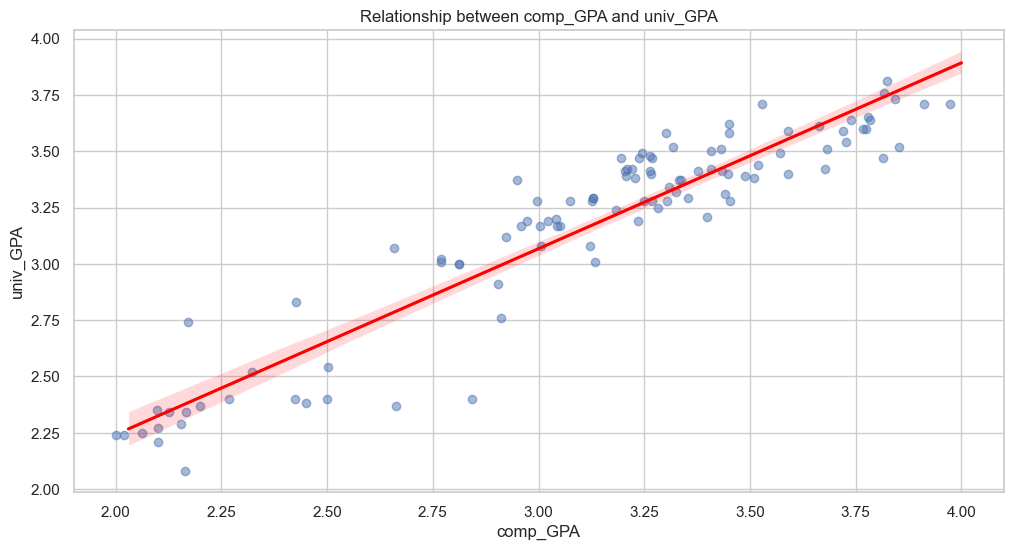

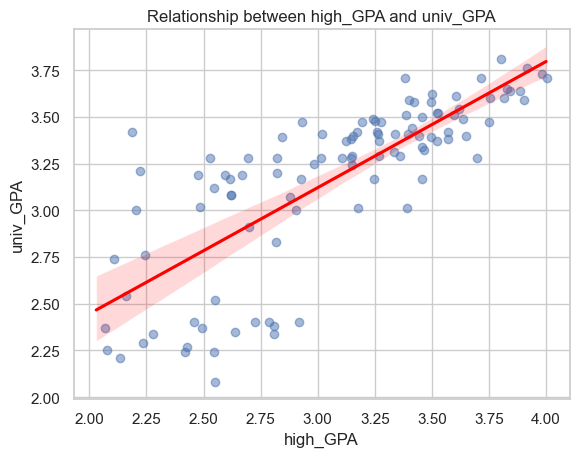

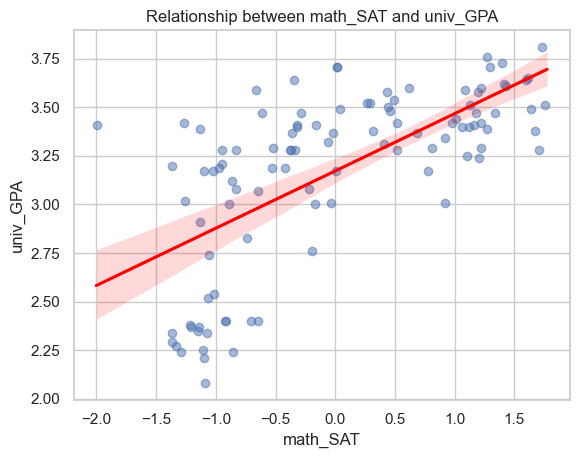

📊 --------------------- Step 7: Splitting Data into Train/Test Sets ---------------------
✅ Data split completed!
   - Training set size: 84 samples
   - Testing  set size: 21 samples


In [4]:
model = Regression_Model(dataset)

In [5]:
model.train()
model.evaluate()

🚀 --------------------- Training Linear Regression Model ---------------------
✅ Model Training Completed!
   - Train Score: 87.94 %
   - Test  Score: 90.67 %
   - Coefficients:
[ 0.10597753 -0.03549358  0.0514796   0.69884703]
   - Intercept: 0.67

🚀 --------------------- Evaluating Model Performance ---------------------
✅ Model Evaluation Completed!
   - Mean   Absolute Error (MAE)   : 0.13
   - Mean   Squared  Error (MSE)   : 0.02
   - Median Absolute Error (MedAE) : 0.12
   - R2 Score: 0.91


In [6]:
model.plot()

📊 Generating Interactive Plots...


✅ All plots generated successfully!


<div style="background-color: #c90016 ; color: #ffffff; width: 100%; height: 50px; text-align: center; font-weight: bold; line-height: 50px; margin: 10px 0; font-size: 24px;">
by Eng\Abdelrhman Ezzat
</div>